## ライブラリー「Darts」を使った時系列分析

In [1]:
# ライブラリーのインポート
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.optim as optim

from darts import TimeSeries
from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler

from darts.models import NaiveMean, NaiveSeasonal, NaiveDrift
from darts.models import ExponentialSmoothing
from darts.models import Theta, FourTheta
from darts.models import ARIMA
from darts.models import FFT
from darts.models import RNNModel
from darts.models import TCNModel
from darts.models import NBEATSModel
from darts.models import TransformerModel
from darts.models import Prophet
from darts.models import AutoARIMA

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

Importing plotly failed. Interactive plots will not work.


In [2]:
# https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html
df = pd.read_csv('../data/AirPassengers.csv')
# データの中身を確認
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
# DartsのTimeSeriesに変換
series = TimeSeries.from_dataframe(df, time_col='Month', value_cols='#Passengers')

Text(0.5, 0, 'Year')

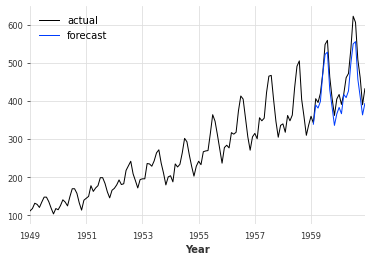

In [4]:
# 1959-01以前と以後に分割
train, val = series.split_after(pd.Timestamp('1959-01'))

# ExponentialSmoothing
# モデル生成
model_es = ExponentialSmoothing()

# 学習
model_es.fit(train) 

# 予測 (predictには予測数を入れることに注意)
historical_fcast_es = model_es.predict(len(val))

# 可視化
series.plot(label='actual', lw=1)
historical_fcast_es.plot(label='forecast', lw=1)
plt.legend()
plt.xlabel('Year')

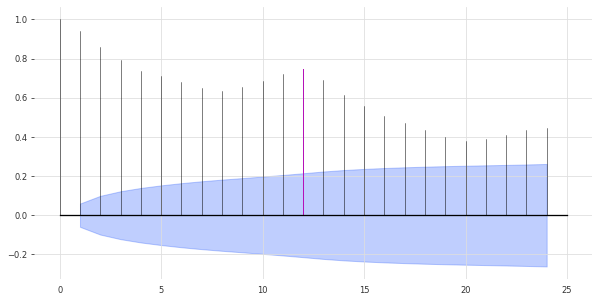

In [5]:
plot_acf(train, m = 12, alpha = .05)

CPU times: user 413 ms, sys: 22.6 ms, total: 436 ms
Wall time: 452 ms


Text(0.5, 0, 'Year')

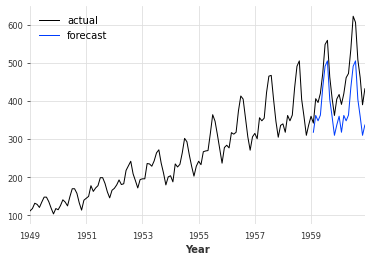

In [6]:
%%time
# NaiveSeasonal
# モデル生成
seasonal_model = NaiveSeasonal(K=12)
# 学習
seasonal_model.fit(train)
# 予測
seasonal_forecast = seasonal_model.predict(len(val))
# 可視化
series.plot(label='actual', lw=1)
seasonal_forecast.plot(label='forecast', lw=1)
plt.legend()
plt.xlabel('Year')

In [7]:
# %%time
# plot_residuals_analysis(seasonal_model.residuals(series))

CPU times: user 475 ms, sys: 6.98 ms, total: 482 ms
Wall time: 542 ms


Text(0.5, 0, 'Year')

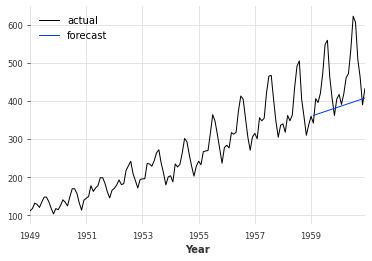

In [8]:
%%time
# NaiveDrift
# モデル生成
drift_model = NaiveDrift()
# 学習
drift_model.fit(train) 
# 予測
drift_forecast = drift_model.predict(len(val))

# 可視化
series.plot(label='actual', lw=1)
drift_forecast.plot(label='forecast', lw=1)
plt.legend()
plt.xlabel('Year')

In [9]:
# %%time
# plot_residuals_analysis(drift_model.residuals(series))

Text(0.5, 0, 'Year')

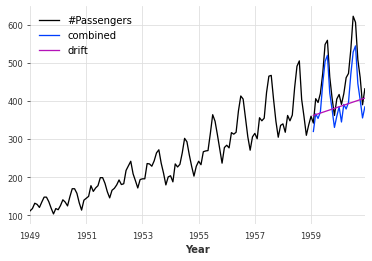

In [10]:
combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label='combined')
drift_forecast.plot(label='drift')
plt.legend()
plt.xlabel('Year')

In [11]:
# Search for the best theta parameter, by trying 50 different values
# Theta
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float('inf')
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)
    
    if res < best_mape:
        best_mape = res
        best_theta = theta

CPU times: user 556 ms, sys: 32.9 ms, total: 589 ms
Wall time: 582 ms


Text(0.5, 0, 'Year')

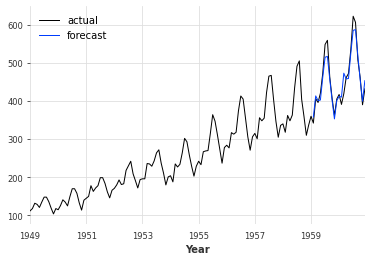

In [12]:
%%time
# Theta
# モデル生成
best_theta_model = Theta(best_theta)
# 学習
best_theta_model.fit(train) 
# 予測
pred_best_theta = best_theta_model.predict(len(val))

# 可視化
series.plot(label='actual', lw=1)
pred_best_theta.plot(label='forecast', lw=1)
plt.legend()
plt.xlabel('Year')

In [13]:
# %%time
# plot_residuals_analysis(best_theta_model.residuals(series))

CPU times: user 953 ms, sys: 22.9 ms, total: 976 ms
Wall time: 1.02 s


Text(0.5, 0, 'Year')

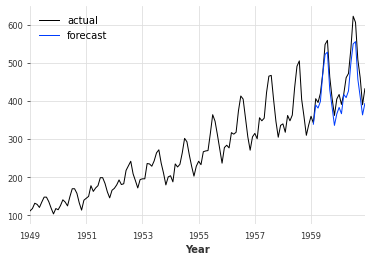

In [14]:
%%time
# ExponentialSmmothing
smoothing_model = ExponentialSmoothing()
smoothing_model.fit(train)
smoothing_prediction = smoothing_model.predict(len(val))

# 可視化
series.plot(label='actual', lw=1)
smoothing_prediction.plot(label='forecast', lw=1)
plt.legend()
plt.xlabel('Year')

In [15]:
# %%time
# plot_residuals_analysis(smoothing_model.residuals(series))

CPU times: user 11.3 s, sys: 6.31 s, total: 17.6 s
Wall time: 9.59 s


Text(0.5, 0, 'Year')

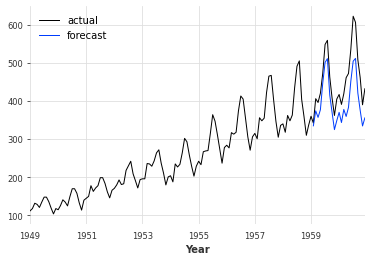

In [16]:
%%time
# ARIMA
arima_model = ARIMA()
arima_model.fit(train)
arima_prediction = arima_model.predict(len(val))

# 可視化
series.plot(label='actual', lw=1)
arima_prediction.plot(label='forecast', lw=1)
plt.legend()
plt.xlabel('Year')

CPU times: user 26.1 s, sys: 19.8 s, total: 45.9 s
Wall time: 24.2 s


Text(0.5, 0, 'Year')

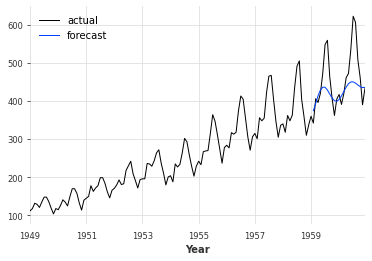

In [17]:
%%time
# AutoARIMA
autoarima_model = AutoARIMA()
autoarima_model.fit(train)
autoarima_prediction = autoarima_model.predict(len(val))

# 可視化
series.plot(label='actual', lw=1)
autoarima_prediction.plot(label='forecast', lw=1)
plt.legend()
plt.xlabel('Year')

In [18]:
# %%time
# plot_residuals_analysis(autoarima_model.residuals(series))

CPU times: user 41.3 s, sys: 4.28 s, total: 45.6 s
Wall time: 47.7 s


Text(0.5, 0, 'Year')

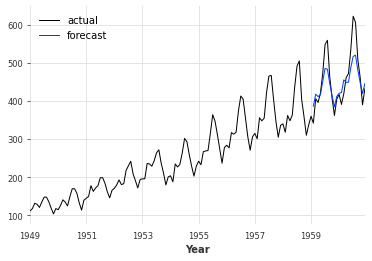

In [19]:
%%time
# Prophet
# モデル生成
prophet_model = Prophet()
# 学習
prophet_model.fit(train) 
# 予測
prophet_prediction = prophet_model.predict(len(val))
# 可視化
series.plot(label='actual', lw=1)
prophet_prediction.plot(label='forecast', lw=1)
plt.legend()
plt.xlabel('Year')

In [20]:
# %%time
# plot_residuals_analysis(prophet_model.residuals(series))

In [21]:
%%time
# LSTM

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

LSTM_model = RNNModel(
    model='LSTM',
    input_chunk_length=12,
    output_chunk_length=1,
    hidden_size=25,
    n_rnn_layers=1,
    dropout=0.4,
    batch_size=16,
    n_epochs=1000,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name='Air_RNN',
    log_tensorboard=True,
    random_state=42
)

LSTM_model.fit(train_transformed, val_series=val_transformed, verbose=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 8min 21s, sys: 58.6 s, total: 9min 20sal loss: 0.0178
Wall time: 7min 39s


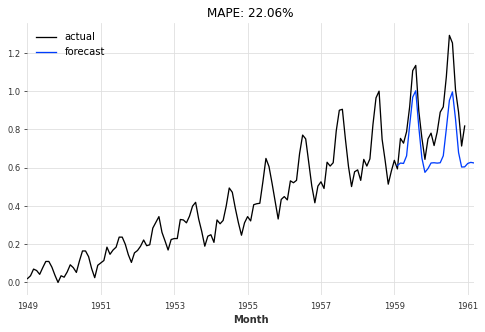

In [22]:
def eval_model(model):
    pred_series = model.predict(n=26)
    plt.figure(figsize=(8,5))
    series_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();

eval_model(LSTM_model)

loading model_best_810.pth.tar


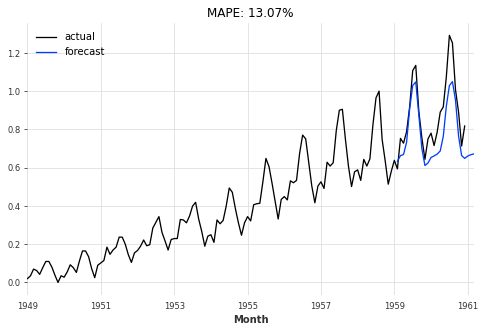

In [23]:
best_model = RNNModel.load_from_checkpoint(model_name='Air_RNN', best=True)
eval_model(best_model)

In [24]:
%%time
# GRU
gru_model = RNNModel(
    model='GRU',
    input_chunk_length=12,
    output_chunk_length=4,
    hidden_size=25,
    n_rnn_layers=1,
    batch_size=64,
    n_epochs=1000,
    dropout=0.2,
    model_name='Air_GRU_out12',
    log_tensorboard=True,
    random_state=42
)

gru_model.fit(train_transformed, val_series=val_transformed, verbose=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 4min 19s, sys: 48.3 s, total: 5min 7sval loss: 0.0455
Wall time: 5min 8s


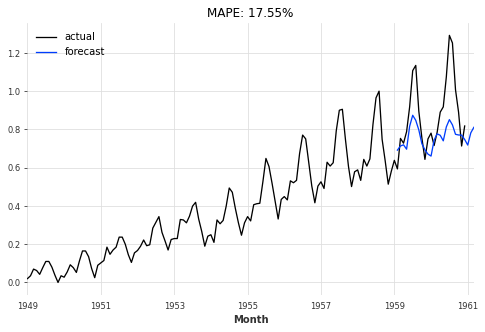

In [25]:
eval_model(gru_model)

loading model_best_970.pth.tar


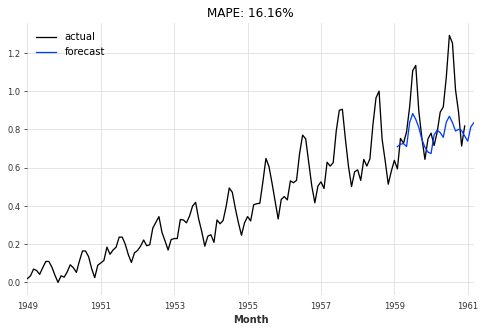

In [26]:
best_model = RNNModel.load_from_checkpoint(model_name='Air_GRU_out12', best=True)
eval_model(best_model)

In [27]:
%%time
#Transformer Model

Transformer_model = TransformerModel(
    input_chunk_length = 12,
    output_chunk_length = 1,
    batch_size = 32,
    n_epochs = 500,
    model_name = 'air_transformer',
    log_tensorboard=True,
    nr_epochs_val_period = 10,
    d_model = 32,
    nhead = 16,
    num_encoder_layers = 3,
    num_decoder_layers = 3,
    dim_feedforward = 512,
    dropout = 0.1,
    activation = "relu",
    random_state=42,
)

Transformer_model.fit(train_transformed, val_series=val_transformed, verbose=True)

  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 22min 53s, sys: 10min 18s, total: 33min 12sss: 0.0049
Wall time: 34min 17s


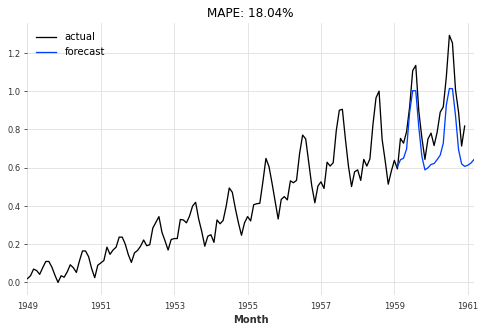

In [28]:
eval_model(Transformer_model)

loading model_best_270.pth.tar


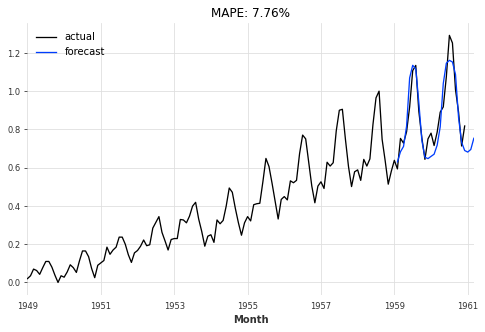

In [29]:
best_model = TransformerModel.load_from_checkpoint(model_name='air_transformer', best=True)
eval_model(best_model)

In [30]:
scaler = Scaler()
ts = scaler.fit_transform(series) 
year_series = datetime_attribute_timeseries(ts, attribute='year')
scaler_year = Scaler()
year_series = scaler_year.fit_transform(year_series)

# 1958-08以前と以後に分割
train, val = ts.split_after(pd.Timestamp('1958-08'))
train_year, val_year = year_series.split_after(pd.Timestamp('1958-08'))

In [31]:
%%time
# TCN Model
TCN_model = TCNModel(
    input_chunk_length=13,
    output_chunk_length=12, 
    n_epochs=400, 
    dropout=0.1, 
    dilation_base=2, 
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0
)

TCN_model.fit(series=train,
              covariates=train_year,
              val_series=val,
              val_covariates=val_year,
              verbose=True)

  0%|          | 0/400 [00:00<?, ?it/s]

CPU times: user 1min 4s, sys: 3.49 s, total: 1min 7s val loss: 0.0013
Wall time: 50.9 s


  0%|          | 0/39 [00:00<?, ?it/s]

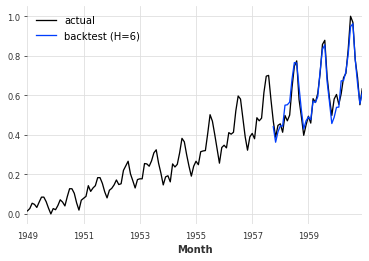

In [32]:
backtest = TCN_model.historical_forecasts(series=ts,
                                          covariates=year_series,
                                          start=0.7,
                                          forecast_horizon=6,
                                          retrain=False,
                                          verbose=True)

ts.plot(label='actual')
backtest.plot(label='backtest (H=6)')
plt.legend()